In [ ]:
from google.cloud import bigquery
from google.cloud import storage
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
warnings.filterwarnings('ignore')

In [ ]:
client = bigquery.Client()
project_id = 'code-for-planet'
dataset_id = 'emission_db'
table_id = 'emissions_final_imputed'

essential_columns = [
    'event_duration_days', 'year', 'doy', 'longitude', 'latitude',
    'covertype', 'fuelcode', 'prefire_fuel',
    'cwd_frac', 'duff_frac', 'fuel_moisture_class',
    'burn_source', 'burnday_source', 'BSEV',
    'fire_region', 'bi_value', 'fm100_value', 'pet_value', 'fm1000_value',
    'pr_value', 'rmax_value', 'rmin_value', 'sph_value', 'srad_value',
    'tmmn_value', 'th_value', 'tmmx_value', 'vpd_value', 'vs_value',
    'fire_date'
]

query = f"""
SELECT {', '.join(essential_columns)}
FROM `{project_id}.{dataset_id}.{table_id}`
WHERE event_duration_days IS NOT NULL
"""

query_job = client.query(query)
df = query_job.to_dataframe()

In [ ]:
for col in df.columns:
    col_type = df[col].dtype
    if col_type != 'object':
        if col_type == 'float64':
            df[col] = df[col].astype('float32')
        elif col_type == 'int64':
            df[col] = df[col].astype('int32')

In [ ]:
df['duration'] = df['event_duration_days'].astype('float32')
df['month'] = pd.to_datetime(df['fire_date']).dt.month.astype('int8')
df['season'] = (pd.to_datetime(df['fire_date']).dt.month%12 // 3 + 1).astype('int8')
df['day_of_year_sin'] = np.sin(2 * np.pi * df['doy'] / 365.25).astype('float32')
df['day_of_year_cos'] = np.cos(2 * np.pi * df['doy'] / 365.25).astype('float32')

df.drop('fire_date', axis=1, inplace=True)

In [ ]:
categorical_features = [
    'covertype', 'fuelcode', 'fuel_moisture_class',
    'burn_source', 'burnday_source', 'BSEV',
]

numerical_features = [
    'longitude', 'latitude', 'prefire_fuel',
    'cwd_frac', 'duff_frac', 'bi_value', 'fm100_value',
    'pet_value', 'fm1000_value', 'pr_value', 'rmax_value', 'rmin_value',
    'sph_value', 'srad_value', 'tmmn_value', 'th_value', 'tmmx_value',
    'vpd_value', 'vs_value',
    'month', 'season', 'day_of_year_sin', 'day_of_year_cos'
]

In [ ]:
label_encoders = {}

for cat_feature in categorical_features:
    if cat_feature in df.columns:
        le = LabelEncoder()
        df[cat_feature] = df[cat_feature].fillna('missing')
        df[cat_feature] = le.fit_transform(df[cat_feature].astype(str)).astype('int16')
        label_encoders[cat_feature] = le

In [ ]:
feature_columns = [col for col in numerical_features + categorical_features if col in df.columns]
df_clean = df.dropna(subset=['duration'])

In [ ]:
pearson_scores = df_clean[feature_columns].corrwith(df_clean['duration']).abs()

spearman_scores = []
for col in feature_columns:
    mask = df_clean[col].notna() & df_clean['duration'].notna()
    if mask.sum() > 0:
        corr, _ = spearmanr(df_clean.loc[mask, col], df_clean.loc[mask, 'duration'])
        spearman_scores.append(abs(corr) if not np.isnan(corr) else 0)
    else:
        spearman_scores.append(0)

spearman_scores = pd.Series(spearman_scores, index=feature_columns)

feature_scores = pd.DataFrame(index=feature_columns)
feature_scores['pearson_correlation'] = pearson_scores
feature_scores['spearman_correlation'] = spearman_scores

In [ ]:
sample_size = min(100000, len(df_clean))
df_sample = df_clean[feature_columns + ['duration']].dropna()
if len(df_sample) > sample_size:
    df_sample = df_sample.sample(n=sample_size, random_state=42)

mi_scores = mutual_info_regression(
    df_sample[feature_columns],
    df_sample['duration'],
    random_state=42
)
feature_scores['mutual_information'] = pd.Series(mi_scores, index=feature_columns)

In [ ]:
df_complete = df_clean[feature_columns + ['duration']].dropna()
if len(df_complete) > 0:
    f_selector = SelectKBest(score_func=f_regression, k='all')
    f_selector.fit(df_complete[feature_columns], df_complete['duration'])
    feature_scores['anova_f'] = pd.Series(f_selector.scores_, index=feature_columns)
else:
    feature_scores['anova_f'] = pd.Series([np.nan] * len(feature_columns), index=feature_columns)

In [ ]:
numerical_cols = [col for col in numerical_features if col in df_clean.columns]
scaler_vif = StandardScaler()
df_vif = df_clean[numerical_cols].dropna()
df_vif_scaled = pd.DataFrame(
    scaler_vif.fit_transform(df_vif),
    columns=numerical_cols,
    index=df_vif.index
)

vif_data = pd.DataFrame()
vif_data["Feature"] = numerical_cols
vif_scores = []

for i in range(len(numerical_cols)):
    try:
        vif = variance_inflation_factor(df_vif_scaled.values, i)
        vif_scores.append(vif)
    except:
        vif_scores.append(np.nan)

vif_data["VIF"] = vif_scores
vif_data = vif_data.sort_values('VIF', ascending=False)

vif_dict = dict(zip(vif_data['Feature'], 1 / (vif_data['VIF'] + 1)))
feature_scores['vif_score'] = pd.Series(vif_dict).reindex(feature_columns).fillna(0)

In [ ]:
rankings = pd.DataFrame(index=feature_columns)

methods = ['pearson_correlation', 'spearman_correlation', 'mutual_information', 'anova_f', 'vif_score']

for method in methods:
    if method in feature_scores.columns:
        scores = feature_scores[method]
        scores_clean = scores.fillna(0)
        rankings[f'{method}_score'] = scores_clean
        rankings[f'{method}_rank'] = scores_clean.rank(ascending=False)

rank_columns = [col for col in rankings.columns if '_rank' in col]
rankings['avg_rank'] = rankings[rank_columns].mean(axis=1)
rankings['final_rank'] = rankings['avg_rank'].rank()

score_columns = [col for col in rankings.columns if '_score' in col]
rankings['avg_score'] = rankings[score_columns].mean(axis=1)

rankings_sorted = rankings.sort_values('final_rank')

In [ ]:
score_columns = [col for col in rankings.columns if '_score' in col and col != 'avg_score']
normalized_scores = rankings[score_columns].copy()

for col in score_columns:
    col_min = normalized_scores[col].min()
    col_max = normalized_scores[col].max()
    if col_max > col_min:
        normalized_scores[col] = (normalized_scores[col] - col_min) / (col_max - col_min)
    else:
        normalized_scores[col] = 0

In [ ]:
correlation_summary = feature_scores[['pearson_correlation', 'spearman_correlation']].copy()
correlation_summary['avg_correlation'] = correlation_summary.mean(axis=1)
correlation_summary = correlation_summary.sort_values('avg_correlation', ascending=False)

print("Top Features by Correlation (Pearson & Spearman):")
print(correlation_summary.head(10).round(3))
print("\n")

mi_summary = feature_scores[['mutual_information']].sort_values('mutual_information', ascending=False)
print("Top Features by Mutual Information:")
print(mi_summary.head(10).round(4))
print("\n")

anova_summary = feature_scores[['anova_f']].sort_values('anova_f', ascending=False)
print("Top Features by ANOVA F-test Score:")
print(anova_summary.head(10).round(2))
print("\n")

print("Top Features by VIF (Low VIF indicates low multicollinearity):")
print(vif_data.head(29))
print("\n")

print("=" * 60)
print("OVERALL FEATURE SELECTION SUMMARY")
print("=" * 60)
print(f"Total features analyzed: {len(feature_columns)}")
print("\nTop 10 features by combined ranking (all methods):")

for i, (feat, rank) in enumerate(rankings_sorted['avg_rank'].head(29).items()):
    scores_str = []
    if feat in feature_scores.index:
        if not pd.isna(feature_scores.loc[feat, 'pearson_correlation']):
            scores_str.append(f"Pearson: {feature_scores.loc[feat, 'pearson_correlation']:.3f}")
        if not pd.isna(feature_scores.loc[feat, 'mutual_information']):
            scores_str.append(f"MI: {feature_scores.loc[feat, 'mutual_information']:.3f}")
        if not pd.isna(feature_scores.loc[feat, 'anova_f']):
            scores_str.append(f"ANOVA: {feature_scores.loc[feat, 'anova_f']:.1f}")
    vif_score = vif_data[vif_data['Feature'] == feat]['VIF']
    if not vif_score.empty:
        scores_str.append(f"VIF: {vif_score.values[0]:.2f}")

    print(f"  {i+1}. {feat} (avg rank: {rank:.2f})")
    if scores_str:
        print(f"     {', '.join(scores_str)}")

Top Features by Correlation (Pearson & Spearman):
                 pearson_correlation  spearman_correlation  avg_correlation
cwd_frac                       0.252                 0.238            0.245
duff_frac                      0.245                 0.238            0.241
longitude                      0.135                 0.221            0.178
prefire_fuel                   0.188                 0.161            0.175
fm1000_value                   0.123                 0.192            0.157
fm100_value                    0.084                 0.166            0.125
day_of_year_sin                0.088                 0.152            0.120
covertype                      0.117                 0.103            0.110
bi_value                       0.081                 0.134            0.107
rmax_value                     0.078                 0.135            0.107


Top Features by Mutual Information:
                 mutual_information
longitude                    0.6891
lati

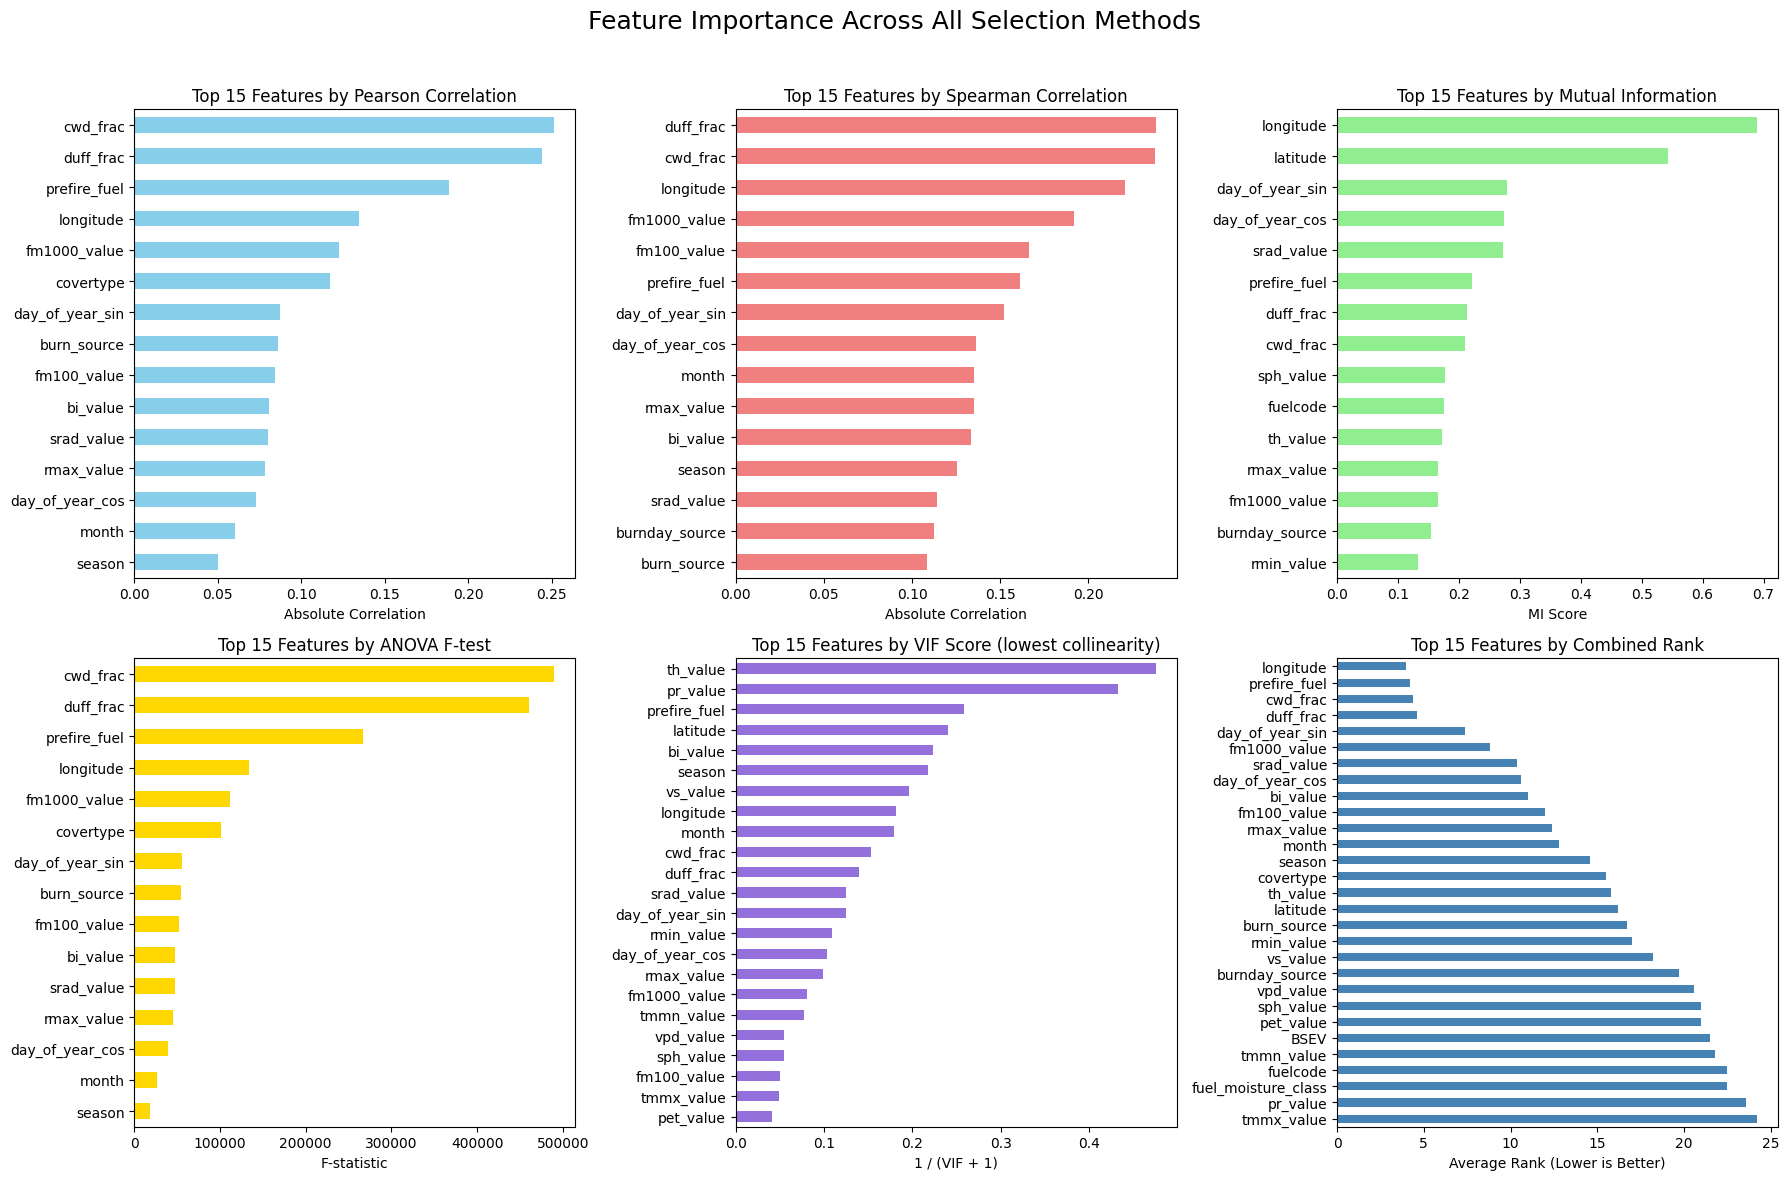

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

feature_scores['pearson_correlation'].abs().sort_values(ascending=False).head(15).plot(
    kind='barh', ax=axes[0], color='skyblue'
)
axes[0].set_title('Top 15 Features by Pearson Correlation')
axes[0].set_xlabel('Absolute Correlation')
axes[0].invert_yaxis()

feature_scores['spearman_correlation'].abs().sort_values(ascending=False).head(15).plot(
    kind='barh', ax=axes[1], color='lightcoral'
)
axes[1].set_title('Top 15 Features by Spearman Correlation')
axes[1].set_xlabel('Absolute Correlation')
axes[1].invert_yaxis()

feature_scores['mutual_information'].sort_values(ascending=False).head(15).plot(
    kind='barh', ax=axes[2], color='lightgreen'
)
axes[2].set_title('Top 15 Features by Mutual Information')
axes[2].set_xlabel('MI Score')
axes[2].invert_yaxis()

feature_scores['anova_f'].sort_values(ascending=False).head(15).plot(
    kind='barh', ax=axes[3], color='gold'
)
axes[3].set_title('Top 15 Features by ANOVA F-test')
axes[3].set_xlabel('F-statistic')
axes[3].invert_yaxis()

vif_data_sorted = vif_data.sort_values('VIF', ascending=True).head(23)
(1 / (vif_data_sorted['VIF'] + 1)).plot(
    kind='barh', ax=axes[4], color='mediumpurple'
)
axes[4].set_yticks(range(len(vif_data_sorted)))
axes[4].set_yticklabels(vif_data_sorted['Feature'])
axes[4].set_title('Top 15 Features by VIF Score (lowest collinearity)')
axes[4].set_xlabel('1 / (VIF + 1)')
axes[4].invert_yaxis()

rankings_sorted['avg_rank'].sort_values(ascending=True).head(29).plot(
    kind='barh', ax=axes[5], color='steelblue'
)
axes[5].set_title('Top 15 Features by Combined Rank')
axes[5].set_xlabel('Average Rank (Lower is Better)')
axes[5].invert_yaxis()

# Final layout
plt.suptitle('Feature Importance Across All Selection Methods', fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


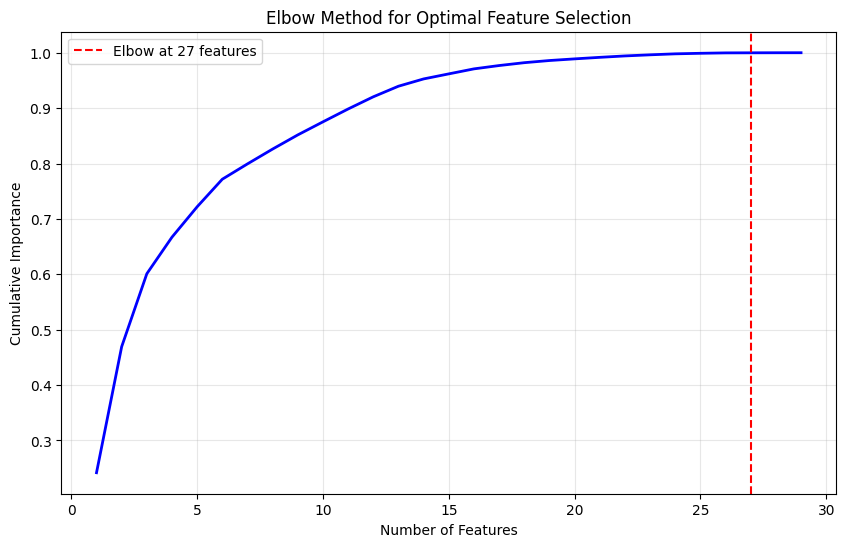

Elbow method suggests using top 27 features


In [ ]:
sorted_scores = rankings_sorted['avg_score'].sort_values(ascending=False)
cumulative_importance = sorted_scores.cumsum() / sorted_scores.sum()

differences = np.diff(cumulative_importance.values)
second_differences = np.diff(differences)
elbow_idx = np.argmax(second_differences) + 2

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_importance) + 1), cumulative_importance.values, 'b-', linewidth=2)
plt.axvline(x=elbow_idx, color='r', linestyle='--', label=f'Elbow at {elbow_idx} features')
plt.xlabel('Number of Features')
plt.ylabel('Cumulative Importance')
plt.title('Elbow Method for Optimal Feature Selection')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

print(f"Elbow method suggests using top {elbow_idx} features")

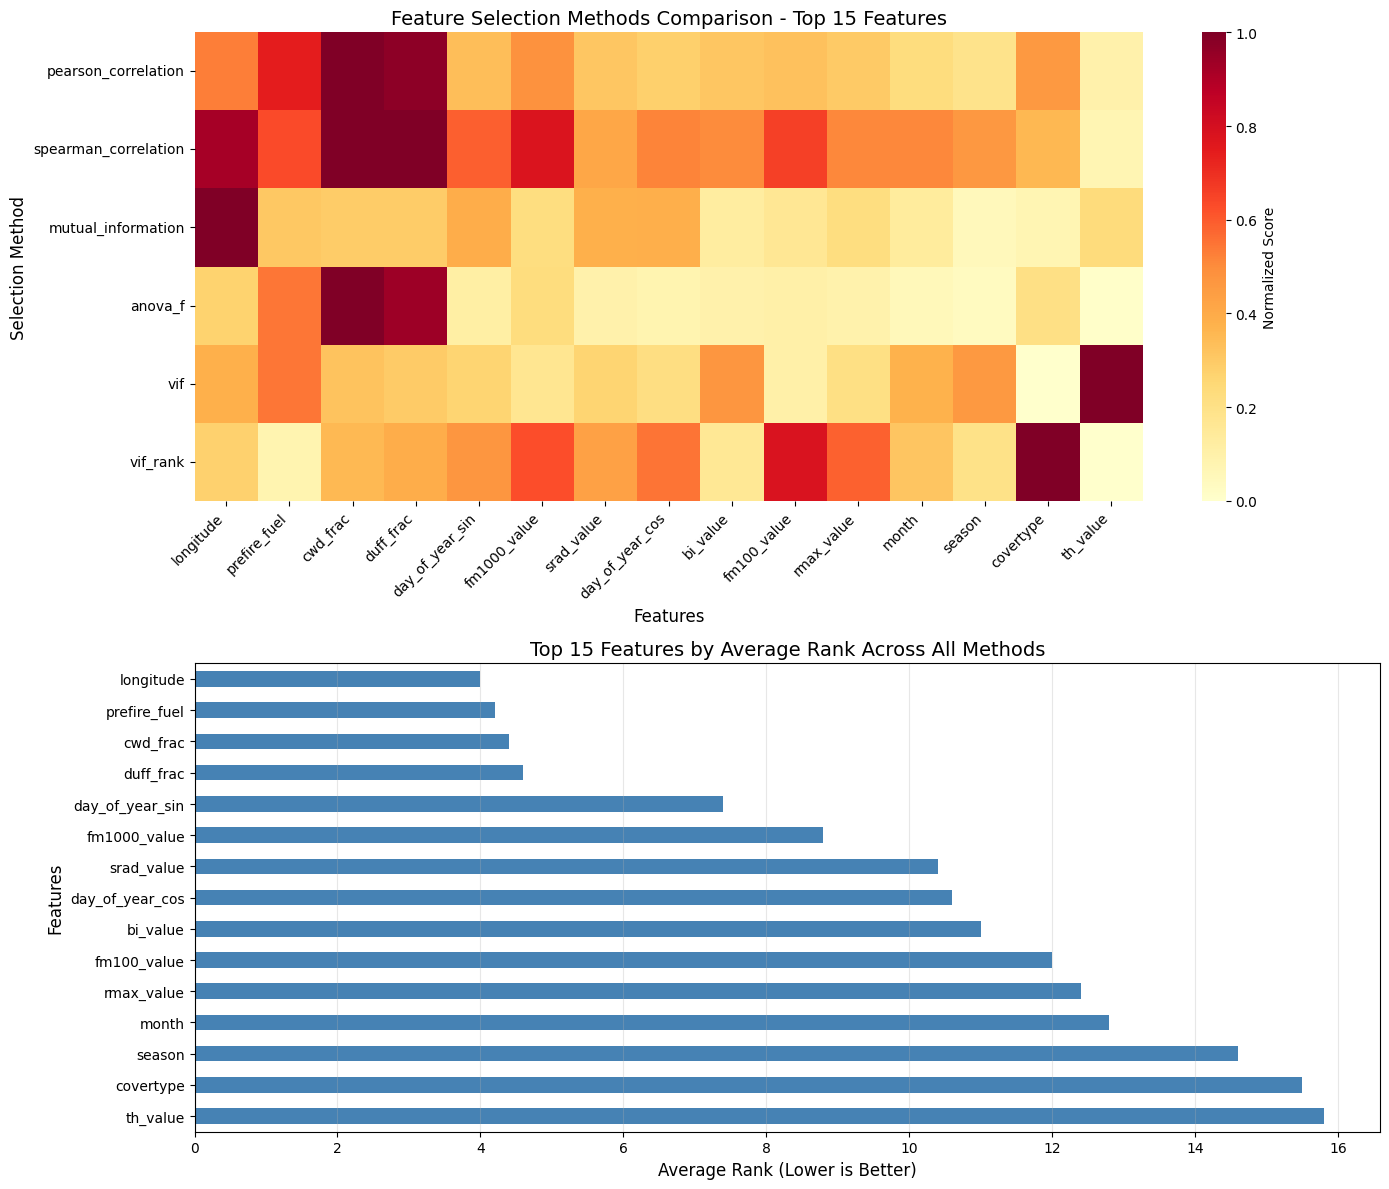

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12))

top_features_viz = rankings_sorted.head(15).index
sns.heatmap(normalized_scores.loc[top_features_viz].T,
            xticklabels=top_features_viz,
            yticklabels=[col.replace('_score', '') for col in score_columns],
            cmap='YlOrRd', ax=ax1, cbar_kws={'label': 'Normalized Score'})
ax1.set_title('Feature Selection Methods Comparison - Top 15 Features', fontsize=14)
ax1.set_xlabel('Features', fontsize=12)
ax1.set_ylabel('Selection Method', fontsize=12)
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')

rankings_sorted.head(15)['avg_rank'].plot(kind='barh', ax=ax2, color='steelblue')
ax2.set_xlabel('Average Rank (Lower is Better)', fontsize=12)
ax2.set_ylabel('Features', fontsize=12)
ax2.set_title('Top 15 Features by Average Rank Across All Methods', fontsize=14)
ax2.invert_yaxis()
ax2.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

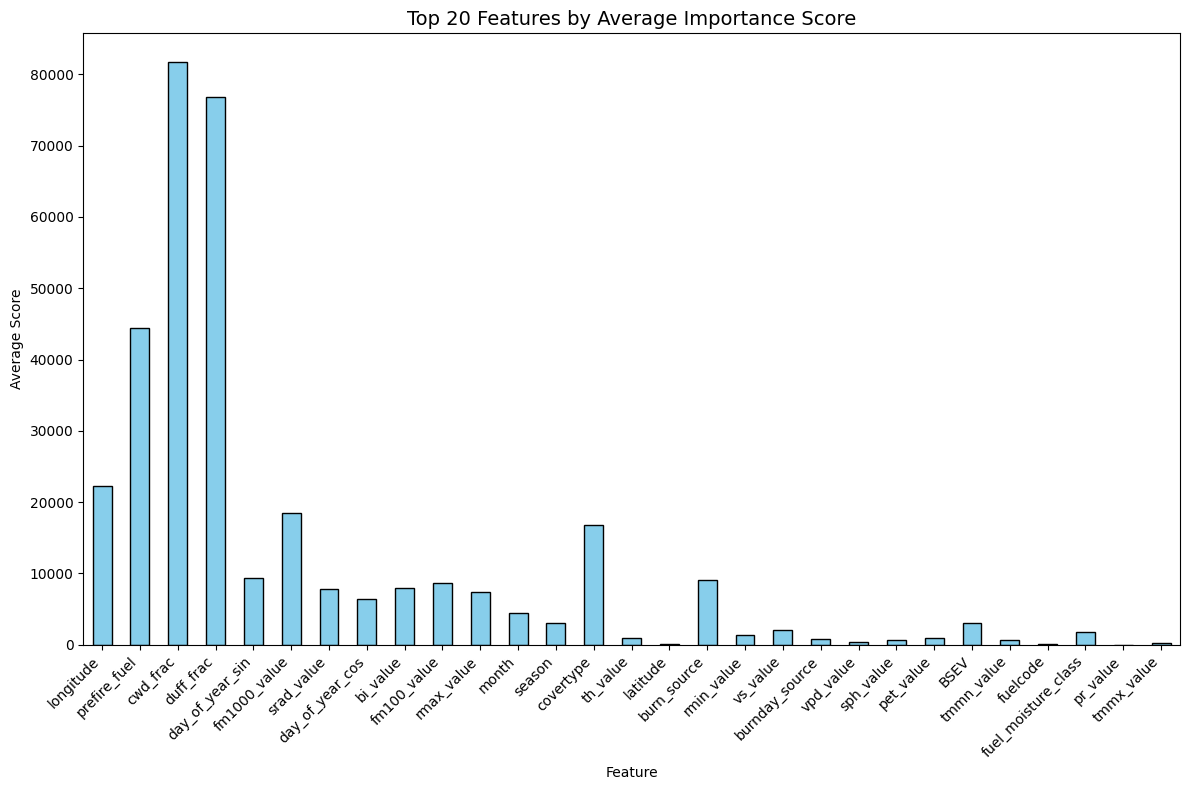

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))

if rankings['avg_score'].notnull().sum() > 0:
    top_features = rankings_sorted.head(29)
    top_features['avg_score'].plot(
        kind='bar',
        ax=ax,
        color='skyblue',
        edgecolor='black'
    )
    ax.set_title('Top 20 Features by Average Importance Score', fontsize=14)
    ax.set_ylabel('Average Score')
    ax.set_xlabel('Feature')
    ax.set_xticklabels(top_features.index, rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

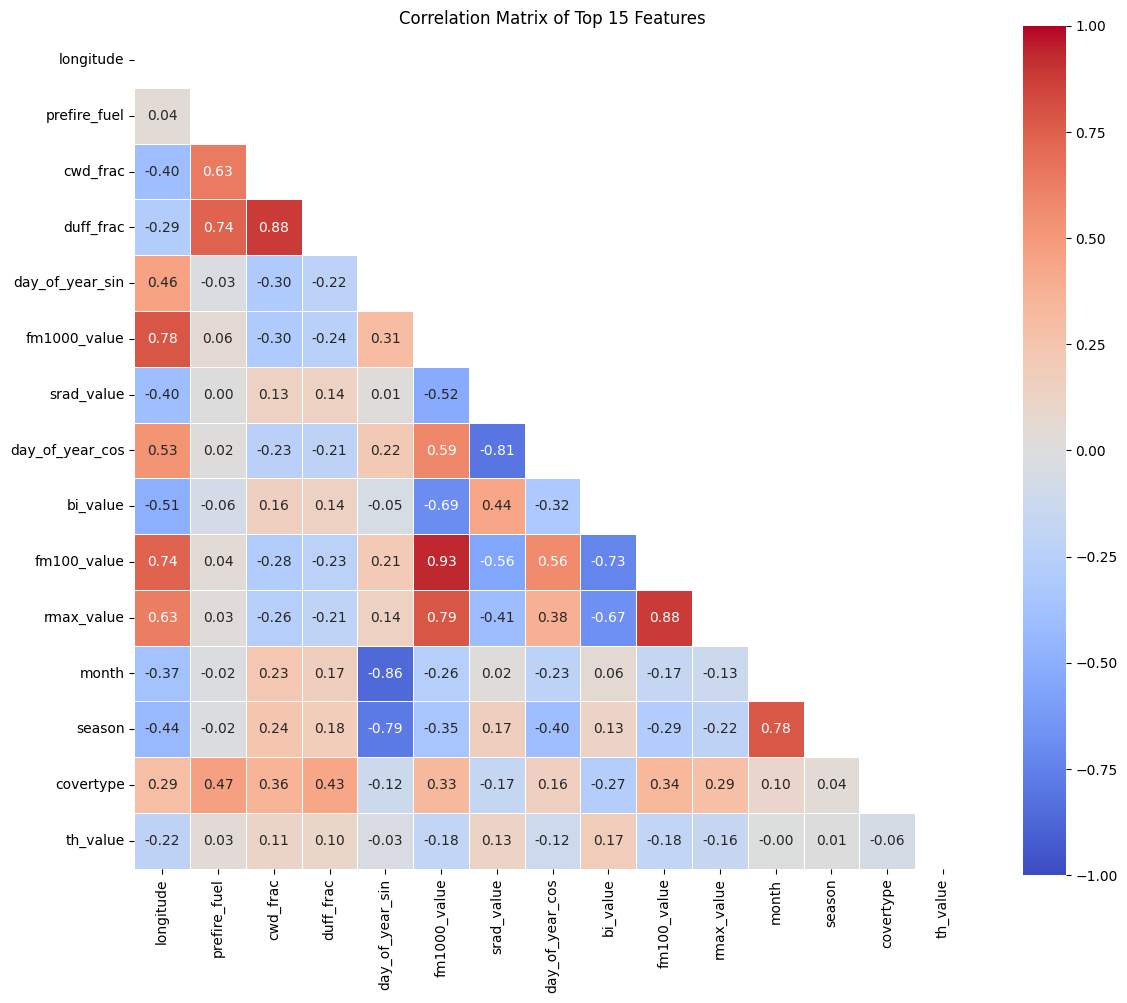

In [ ]:
n_top_features = min(elbow_idx, 15)
top_features = rankings_sorted.head(n_top_features).index.tolist()

corr_matrix = df_clean[top_features].corr()

plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f',
            cmap='coolwarm', center=0, vmin=-1, vmax=1,
            square=True, linewidths=0.5)
plt.title(f'Correlation Matrix of Top {n_top_features} Features')
plt.tight_layout()
plt.show()

In [ ]:
k_features_optimal = elbow_idx
k_features_full = 29
k_features_minimal = 10

top_features_optimal = rankings_sorted.head(k_features_optimal).index.tolist()
top_features_full = rankings_sorted.head(k_features_full).index.tolist()
top_features_minimal = rankings_sorted.head(k_features_minimal).index.tolist()

print(f"Optimal features ({k_features_optimal}): {top_features_optimal}")
print(f"\nFull feature set ({k_features_full}): {top_features_full}")
print(f"\nMinimal feature set ({k_features_minimal}): {top_features_minimal}")

Optimal features (27): ['longitude', 'prefire_fuel', 'cwd_frac', 'duff_frac', 'day_of_year_sin', 'fm1000_value', 'srad_value', 'day_of_year_cos', 'bi_value', 'fm100_value', 'rmax_value', 'month', 'season', 'covertype', 'th_value', 'latitude', 'burn_source', 'rmin_value', 'vs_value', 'burnday_source', 'vpd_value', 'sph_value', 'pet_value', 'BSEV', 'tmmn_value', 'fuelcode', 'fuel_moisture_class']

Full feature set (29): ['longitude', 'prefire_fuel', 'cwd_frac', 'duff_frac', 'day_of_year_sin', 'fm1000_value', 'srad_value', 'day_of_year_cos', 'bi_value', 'fm100_value', 'rmax_value', 'month', 'season', 'covertype', 'th_value', 'latitude', 'burn_source', 'rmin_value', 'vs_value', 'burnday_source', 'vpd_value', 'sph_value', 'pet_value', 'BSEV', 'tmmn_value', 'fuelcode', 'fuel_moisture_class', 'pr_value', 'tmmx_value']

Minimal feature set (10): ['longitude', 'prefire_fuel', 'cwd_frac', 'duff_frac', 'day_of_year_sin', 'fm1000_value', 'srad_value', 'day_of_year_cos', 'bi_value', 'fm100_value']


In [ ]:
X = df_clean[top_features_optimal]
y = df_clean['duration']

# train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# standardize numerical features
scaler = StandardScaler()
numerical_cols = [col for col in numerical_features if col in X.columns]

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

if numerical_cols:
    X_train_scaled[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
    X_test_scaled[numerical_cols] = scaler.transform(X_test[numerical_cols])

train_df = X_train_scaled.copy()
train_df['duration'] = y_train.values

test_df = X_test_scaled.copy()
test_df['duration'] = y_test.values

In [ ]:
# save feature rankings
rankings_sorted.to_csv('feature_selection_rankings.csv')
pd.DataFrame({'feature': top_features_optimal}).to_csv('selected_features_optimal.csv', index=False)
vif_data.to_csv('vif_analysis.csv', index=False)

bucket_name = 'data_housee'
storage_client = storage.Client()

# save train/test data
train_df.to_parquet(
    f'gs://{bucket_name}/wildfire_ml/train_data.parquet',
    engine='pyarrow',
    compression='snappy',
    index=False
)

test_df.to_parquet(
    f'gs://{bucket_name}/wildfire_ml/test_data.parquet',
    engine='pyarrow',
    compression='snappy',
    index=False
)

# save preprocessing artifacts
preprocessing_artifacts = {
    'scaler': scaler,
    'label_encoders': label_encoders,
    'selected_features': top_features_optimal,
    'numerical_cols': numerical_cols,
    'categorical_features': categorical_features,
    'feature_rankings': rankings_sorted,
    'vif_analysis': vif_data,
    'optimal_n_features': k_features_optimal
}

local_path = 'preprocessing_artifacts.pkl'
joblib.dump(preprocessing_artifacts, local_path)

bucket = storage_client.bucket(bucket_name)
blob = bucket.blob('wildfire_ml/preprocessing_artifacts.pkl')
blob.upload_from_filename(local_path)

print(f"Optimal number of features: {k_features_optimal}")
print(f"Data saved to gs://{bucket_name}/wildfire_ml/")

Optimal number of features: 27
Data saved to gs://data_housee/wildfire_ml/
